In [1]:
import pandas as pd
from modules import Agent,Model
from DCAStrategy import DCAAgent
from LSStrategy import LSSAgent
import numpy as np
import torch
import pickle
device = "cuda" if torch.cuda.is_available() else "cpu"
import matplotlib.pyplot as plt
import seaborn as sns
import os
from preprocessing import Feature_Extractor, data_preprocessing


Start Trading

In [2]:
symbol = "BSI"

In [3]:
df = pd.read_csv(f'DataTraining/{symbol}.csv')

In [4]:
df.tail

<bound method NDFrame.tail of             Date    Close     Open     High      Low
0     2014-01-20   6500.0   7000.0   7000.0   6500.0
1     2014-01-21   6300.0   6500.0   6600.0   6300.0
2     2014-01-22   6200.0   6300.0   6500.0   6100.0
3     2014-01-23   6600.0   6200.0   6600.0   6200.0
4     2014-01-24   6400.0   6600.0   6600.0   6300.0
...          ...      ...      ...      ...      ...
2576  2024-06-12  60800.0  60600.0  62200.0  60500.0
2577  2024-06-13  60200.0  61300.0  61300.0  60000.0
2578  2024-06-14  58000.0  60800.0  61200.0  58000.0
2579  2024-06-17  57300.0  57800.0  58000.0  57100.0
2580  2024-06-18  57500.0  57900.0  57900.0  57000.0

[2581 rows x 5 columns]>

Trade without LSTM

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df_init = df[['Close']]  
df_init = data_preprocessing(df_init, Feature_Extractor)
real_trend = df_init['Close'].tolist()
parameters = [df_init[cl].tolist() for cl in df_init.columns]
minmax = pickle.load(open(f"checkpoint/{symbol}_scaler.pkl", 'rb'))
scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
with open(f"checkpoint/{symbol}_model.pkl", 'rb') as fopen:
    model = pickle.load(fopen)
# initial_money = np.max(parameters[0]) * 3
initial_money= 2000000
skip = 1
from_date ="2023-05-18"
to_date = "2024-06-18"
from_date = pd.to_datetime(from_date)
to_date = pd.to_datetime(to_date)
df = df[['Date', 'Close']]
#Preprocess Dataframe
df = data_preprocessing(df, Feature_Extractor)
selected_data = df.loc[(df['Date'] >= from_date) & (df['Date'] <= to_date),:]
data_list = selected_data.values.tolist()

In [ ]:
agent = Agent(model = model,
                timeseries = scaled_parameters,
                skip = skip,
                initial_money = initial_money,
                real_trend = real_trend,
                minmax = minmax,
                window_size = 10)

In [ ]:
trade_results = []
for row in data_list:
    #ensure first column is Date
    date = row[0]
    value = row[1:]
    result = agent.trade(value, date = date)
    trade_results.append(result)

[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[1.00000000e+00 0.00000000e+00 9.04605322e-86]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 

In [ ]:
result = pd.DataFrame(trade_results)

# Convert the 'date' column to datetime format
result['date'] = pd.to_datetime(result['date'])

In [ ]:
result

,status,action,close,balance,timestamp,date,total,investment,total_investment,all_bought,all_sold,gain
0,data not enough to trade,0,27303.0,2000000.0,2024-06-19 21:00:42.861357,2023-05-18,NaN,NaN,NaN,NaN,NaN,NaN
1,data not enough to trade,0,27063.0,2000000.0,2024-06-19 21:00:42.861357,2023-05-19,NaN,NaN,NaN,NaN,NaN,NaN
2,data not enough to trade,0,27782.0,2000000.0,2024-06-19 21:00:42.861357,2023-05-22,NaN,NaN,NaN,NaN,NaN,NaN
3,data not enough to trade,0,27398.0,2000000.0,2024-06-19 21:00:42.861357,2023-05-23,NaN,NaN,NaN,NaN,NaN,NaN
4,data not enough to trade,0,29314.0,2000000.0,2024-06-19 21:00:42.861357,2023-05-24,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
267,do nothing,0,60800.0,2003544.0,2024-06-19 21:00:43.015257,2024-06-12,2003544.0,NaN,NaN,NaN,NaN,NaN
268,do nothing,0,60200.0,2003544.0,2024-06-19 21:00:43.015257,2024-06-13,2003544.0,NaN,NaN,NaN,NaN,NaN
269,do nothing,0,58000.0,2003544.0,2024-06-19 21:00:43.016261,2024-06-14,2003544.0,NaN,NaN,NaN,NaN,NaN
270,do nothing,0,57300.0,2003544.0,2024-06-19 21:00:43.016261,2024-06-17,2003544.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_action_2 = result[result['action'] == 2]

# Sắp xếp DataFrame theo timestamp hoặc date để đảm bảo lấy hàng cuối cùng
df_action_2_sorted = df_action_2.sort_values(by='date')

# Lấy giá trị total_investment của hàng cuối cùng
last_total_investment = df_action_2_sorted.iloc[-1]['total_investment']
df_sorted = result.sort_values(by='date')

# Lấy giá trị total của hàng cuối cùng
last_total = df_sorted.iloc[-1]['total']
investmentvalue = (last_total-initial_money)/initial_money *100
total_gain = result['gain'].sum()
investGain = total_gain/initial_money *100

0.6421592786942278
0.1772
3543.9999999999854
0.17719999999999927


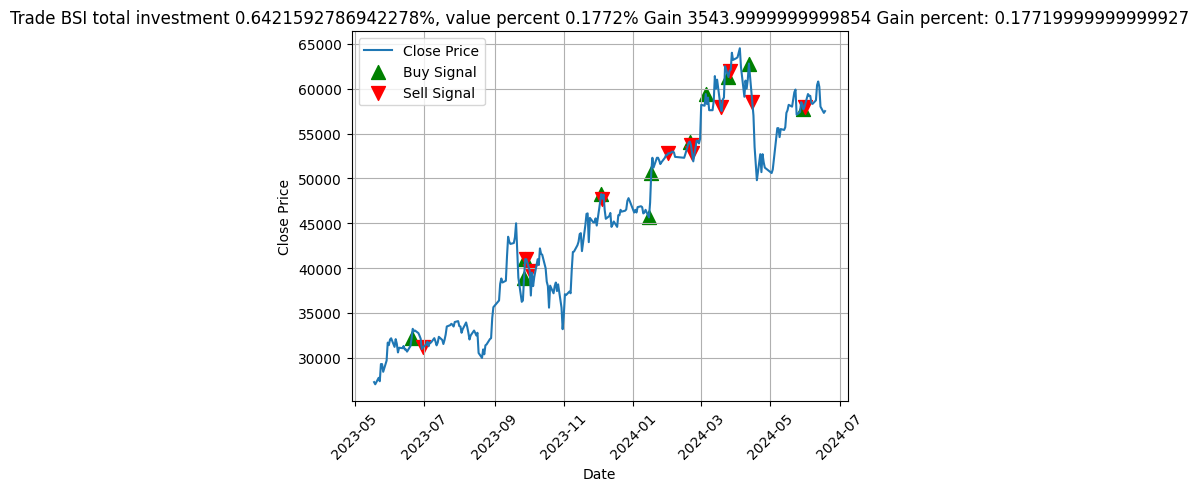

In [ ]:
print(last_total_investment)
print(investmentvalue)
print(total_gain)
print(investGain)

# Mark buy and sell actions
buy_signals = result[result['action'] == 1]
sell_signals = result[result['action'] == 2]
plt.plot(result['date'], result['close'], linestyle='-', label='Close Price')

plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='g', s=100, label='Buy Signal')
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='r', s=100, label='Sell Signal')

# Customize the plot
plt.title(f'Trade {symbol} total investment {last_total_investment}%, value percent {investmentvalue}% Gain {total_gain} Gain percent: {investGain}')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()

With LSTM

In [ ]:
df = pd.read_csv(f'DataTraining/{symbol}.csv')
df['Date'] = pd.to_datetime(df['Date'])
df_init = df[['Close']]  
df_init = data_preprocessing(df_init, Feature_Extractor)
real_trend = df_init['Close'].tolist()
parameters = [df_init[cl].tolist() for cl in df_init.columns]
# initial_money = np.max(parameters[0]) * 3
initial_money = 500000
minmax = pickle.load(open(f"checkpoint/{symbol}prediction_scaler.pkl", 'rb'))
scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
with open(f"checkpoint/{symbol}prediction_model.pkl", 'rb') as fopen:
    model = pickle.load(fopen)
df = df[['Date', 'Close']]
#Preprocess Dataframe
df = data_preprocessing(df, Feature_Extractor)
selected_data = df.loc[(df['Date'] >= from_date) & (df['Date'] <= to_date),:]
data_list = selected_data.values.tolist()

c:\Users\hotua\anaconda3\envs\venv\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
agent2 = Agent(model = model,
                timeseries = scaled_parameters,
                skip = skip,
                initial_money = initial_money,
                real_trend = real_trend,
                minmax = minmax,
                window_size = 10)

In [ ]:
trade_results = []
for row in data_list:
    #ensure first column is Date
    date = row[0]
    value = row[1:]
    result = agent2.trade(value, date = date)
    trade_results.append(result)

[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0.00000000e+000 1.00000000e+000 2.30880285e-259]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]


In [ ]:
result = pd.DataFrame(trade_results)

# Convert the 'date' column to datetime format
result['date'] = pd.to_datetime(result['date'])
# total_gain = result['gain'].sum()
# total_investment = result['investment'].sum()

In [ ]:
result

,status,action,close,balance,timestamp,date,total,investment,total_investment,all_bought,all_sold,gain
0,data not enough to trade,0,28100.0,500000.0,2024-06-18 20:43:32.608878,2024-05-06,NaN,NaN,NaN,NaN,NaN,NaN
1,data not enough to trade,0,28300.0,500000.0,2024-06-18 20:43:32.608878,2024-05-07,NaN,NaN,NaN,NaN,NaN,NaN
2,data not enough to trade,0,27950.0,500000.0,2024-06-18 20:43:32.610347,2024-05-08,NaN,NaN,NaN,NaN,NaN,NaN
3,data not enough to trade,0,27800.0,500000.0,2024-06-18 20:43:32.610347,2024-05-09,NaN,NaN,NaN,NaN,NaN,NaN
4,data not enough to trade,0,27600.0,500000.0,2024-06-18 20:43:32.610347,2024-05-10,NaN,NaN,NaN,NaN,NaN,NaN
5,data not enough to trade,0,27250.0,500000.0,2024-06-18 20:43:32.610347,2024-05-13,NaN,NaN,NaN,NaN,NaN,NaN
6,data not enough to trade,0,27250.0,500000.0,2024-06-18 20:43:32.610347,2024-05-14,NaN,NaN,NaN,NaN,NaN,NaN
7,data not enough to trade,0,27800.0,500000.0,2024-06-18 20:43:32.610347,2024-05-15,NaN,NaN,NaN,NaN,NaN,NaN
8,data not enough to trade,0,28400.0,500000.0,2024-06-18 20:43:32.611621,2024-05-16,NaN,NaN,NaN,NaN,NaN,NaN
9,"buy 1 unit, cost 28500.000000",1,28500.0,471500.0,2024-06-18 20:43:32.612128,2024-05-17,500000.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_action_2 = result[result['action'] == 2]

# Sắp xếp DataFrame theo timestamp hoặc date để đảm bảo lấy hàng cuối cùng
df_action_2_sorted = df_action_2.sort_values(by='date')

# Lấy giá trị total_investment của hàng cuối cùng
last_total_investment = df_action_2_sorted.iloc[-1]['total_investment']
df_sorted = result.sort_values(by='date')

# Lấy giá trị total của hàng cuối cùng
last_total = df_sorted.iloc[-1]['total']
investmentvalue = (last_total-initial_money)/initial_money *100
total_gain = result['gain'].sum()
investGain = total_gain/initial_money *100

1.7851012701682114
0.52
2600.0
0.52


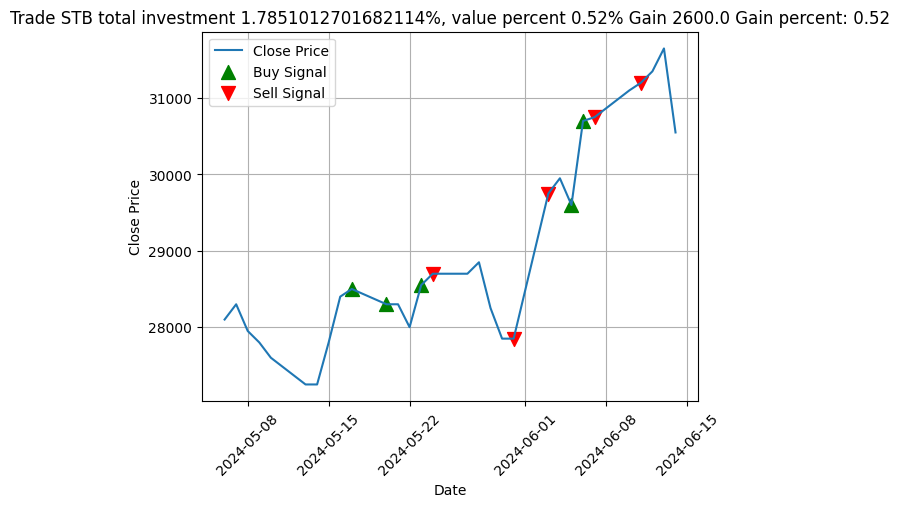

In [ ]:
print(last_total_investment)
print(investmentvalue)
print(total_gain)
print(investGain)

# Mark buy and sell actions
buy_signals = result[result['action'] == 1]
sell_signals = result[result['action'] == 2]
plt.plot(result['date'], result['close'], linestyle='-', label='Close Price')

plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='g', s=100, label='Buy Signal')
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='r', s=100, label='Sell Signal')

# Customize the plot
plt.title(f'Trade {symbol} total investment {last_total_investment}%, value percent {investmentvalue}% Gain {total_gain} Gain percent: {investGain}')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()

DCA without LSTM

In [48]:
df = pd.read_csv(f'DataTraining/{symbol}.csv')
df['Date'] = pd.to_datetime(df['Date'])
df_init = df[['Close']]  
df_init = data_preprocessing(df_init, Feature_Extractor)
real_trend = df_init['Close'].tolist()
parameters = [df_init[cl].tolist() for cl in df_init.columns]
# initial_money = np.max(parameters[0]) * 5
initial_money =  5000000
minmax = pickle.load(open(f"checkpoint/{symbol}_DCAscaler.pkl", 'rb'))
scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
with open(f"checkpoint/{symbol}_DCAmodel.pkl", 'rb') as fopen:
    model = pickle.load(fopen)
df = df[['Date', 'Close']]
#Preprocess Dataframe
df = data_preprocessing(df, Feature_Extractor)
selected_data = df.loc[(df['Date'] >= from_date) & (df['Date'] <= to_date),:]
data_list = selected_data.values.tolist()

In [49]:
agent3 = DCAAgent(model = model,
                timeseries = scaled_parameters,
                skip = skip,
                initial_money = initial_money,
                real_trend = real_trend,
                minmax = minmax,
                window_size = 10)

In [50]:
trade_results = []
for row in data_list:
    #ensure first column is Date
    date = row[0]
    value = row[1:]
    result = agent3.trade(value, date = date)
    trade_results.append(result)

[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1.000000e+000 0.000000e+000 1.996336e-318]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1.00000000e+000 0.00000000e+000 6.28549078e-274]
[0. 

In [51]:
result = pd.DataFrame(trade_results)

# Convert the 'date' column to datetime format
result['date'] = pd.to_datetime(result['date'])
# total_gain = result['gain'].sum()
# total_investment = result['investment'].sum()

In [45]:
result

,status,action,close,balance,timestamp,date,total,investment,average_investment,all_bought,all_sold,total_investment,gain,total_sold
0,data not enough to trade,0,27303.0,3000000.0,2024-06-19 22:25:58.987168,2023-05-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,data not enough to trade,0,27063.0,3000000.0,2024-06-19 22:25:58.987168,2023-05-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,data not enough to trade,0,27782.0,3000000.0,2024-06-19 22:25:58.987168,2023-05-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,data not enough to trade,0,27398.0,3000000.0,2024-06-19 22:25:58.987168,2023-05-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,data not enough to trade,0,29314.0,3000000.0,2024-06-19 22:25:58.987168,2023-05-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,"buy 1 unit, cost 60800.000000",1,60800.0,2911562.0,2024-06-19 22:25:59.217669,2024-06-12,3093962.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
268,"buy 1 unit, cost 60200.000000",1,60200.0,2851362.0,2024-06-19 22:25:59.218670,2024-06-13,3092162.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
269,do nothing,0,58000.0,2851362.0,2024-06-19 22:25:59.219680,2024-06-14,3083362.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
270,do nothing,0,57300.0,2851362.0,2024-06-19 22:25:59.219680,2024-06-17,3080562.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
df_action_2 = result[result['action'] == 2]

# Sắp xếp DataFrame theo timestamp hoặc date để đảm bảo lấy hàng cuối cùng
df_action_2_sorted = df_action_2.sort_values(by='date')

# Lấy giá trị total_investment của hàng cuối cùng
last_total_investment = df_action_2_sorted.iloc[-1]['total_investment']
df_sorted = result.sort_values(by='date')

# Lấy giá trị total của hàng cuối cùng
last_total = df_sorted.iloc[-1]['total']
investmentvalue = (last_total-initial_money)/initial_money *100
total_gain = result['gain'].sum()
investGain = total_gain/initial_money *100

2.2173535248099303
1.93224
96611.99999999999
1.9322399999999997


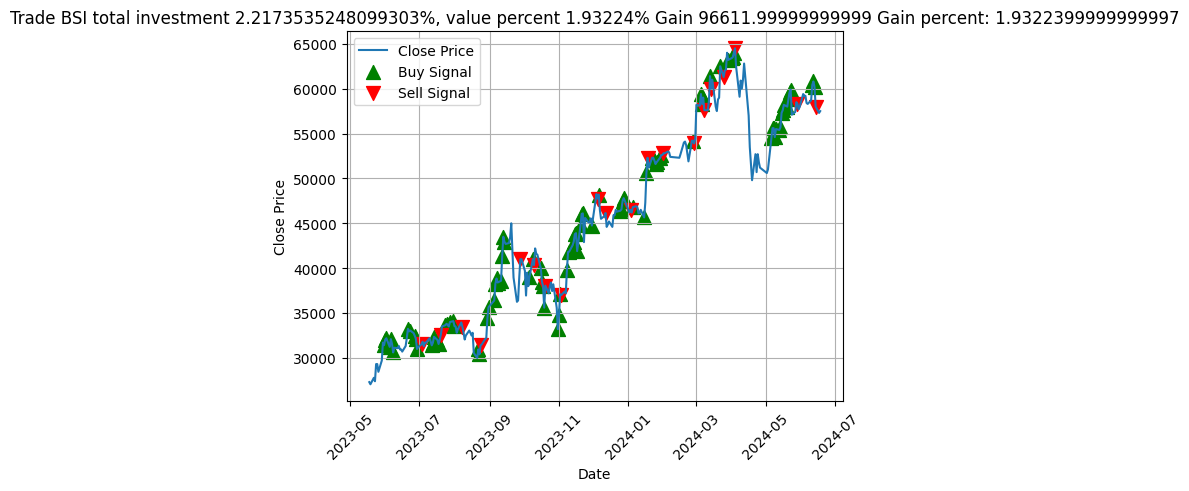

In [53]:
print(last_total_investment)
print(investmentvalue)
print(total_gain)
print(investGain)

# Mark buy and sell actions
buy_signals = result[result['action'] == 1]
sell_signals = result[result['action'] == 2]
plt.plot(result['date'], result['close'], linestyle='-', label='Close Price')

plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='g', s=100, label='Buy Signal')
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='r', s=100, label='Sell Signal')

# Customize the plot
plt.title(f'Trade {symbol} total investment {last_total_investment}%, value percent {investmentvalue}% Gain {total_gain} Gain percent: {investGain}')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()

DCA with LSTM

In [ ]:
df = pd.read_csv(f'DataTraining/{symbol}.csv')
df['Date'] = pd.to_datetime(df['Date'])
df_init = df[['Close']]  
df_init = data_preprocessing(df_init, Feature_Extractor)
real_trend = df_init['Close'].tolist()
parameters = [df_init[cl].tolist() for cl in df_init.columns]
initial_money = 500000
minmax = pickle.load(open(f"checkpoint/{symbol}Prediction_DCAscaler.pkl", 'rb'))
scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
with open(f"checkpoint/{symbol}Prediction_DCAmodel.pkl", 'rb') as fopen:
    model = pickle.load(fopen)
df = df[['Date', 'Close']]
#Preprocess Dataframe
df = data_preprocessing(df, Feature_Extractor)
selected_data = df.loc[(df['Date'] >= from_date) & (df['Date'] <= to_date),:]
data_list = selected_data.values.tolist()

c:\Users\hotua\anaconda3\envs\venv\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
agent4 = DCAAgent(model = model,
                timeseries = scaled_parameters,
                skip = skip,
                initial_money = initial_money,
                real_trend = real_trend,
                minmax = minmax,
                window_size = 10)

In [ ]:
trade_results = []
for row in data_list:
    #ensure first column is Date
    date = row[0]
    value = row[1:]
    result = agent4.trade(value, date = date)
    trade_results.append(result)

[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]


In [ ]:
trade_results

[{'status': 'data not enough to trade',
  'action': 0,
  'close': 28100.0,
  'balance': 500000,
  'timestamp': '2024-06-18 20:43:33.638954',
  'date': '2024-05-06'},
 {'status': 'data not enough to trade',
  'action': 0,
  'close': 28300.0,
  'balance': 500000,
  'timestamp': '2024-06-18 20:43:33.638954',
  'date': '2024-05-07'},
 {'status': 'data not enough to trade',
  'action': 0,
  'close': 27950.0,
  'balance': 500000,
  'timestamp': '2024-06-18 20:43:33.638954',
  'date': '2024-05-08'},
 {'status': 'data not enough to trade',
  'action': 0,
  'close': 27800.0,
  'balance': 500000,
  'timestamp': '2024-06-18 20:43:33.638954',
  'date': '2024-05-09'},
 {'status': 'data not enough to trade',
  'action': 0,
  'close': 27600.0,
  'balance': 500000,
  'timestamp': '2024-06-18 20:43:33.638954',
  'date': '2024-05-10'},
 {'status': 'data not enough to trade',
  'action': 0,
  'close': 27250.0,
  'balance': 500000,
  'timestamp': '2024-06-18 20:43:33.638954',
  'date': '2024-05-13'},
 {'s

In [ ]:
result = pd.DataFrame(trade_results)

# Convert the 'date' column to datetime format
result['date'] = pd.to_datetime(result['date'])
# total_gain = result['gain'].sum()
# total_investment = result['investment'].sum()

In [ ]:
result

,status,action,close,balance,timestamp,date,total
0,data not enough to trade,0,28100.0,500000.0,2024-06-18 20:43:33.638954,2024-05-06,NaN
1,data not enough to trade,0,28300.0,500000.0,2024-06-18 20:43:33.638954,2024-05-07,NaN
2,data not enough to trade,0,27950.0,500000.0,2024-06-18 20:43:33.638954,2024-05-08,NaN
3,data not enough to trade,0,27800.0,500000.0,2024-06-18 20:43:33.638954,2024-05-09,NaN
4,data not enough to trade,0,27600.0,500000.0,2024-06-18 20:43:33.638954,2024-05-10,NaN
5,data not enough to trade,0,27250.0,500000.0,2024-06-18 20:43:33.638954,2024-05-13,NaN
6,data not enough to trade,0,27250.0,500000.0,2024-06-18 20:43:33.638954,2024-05-14,NaN
7,data not enough to trade,0,27800.0,500000.0,2024-06-18 20:43:33.638954,2024-05-15,NaN
8,data not enough to trade,0,28400.0,500000.0,2024-06-18 20:43:33.638954,2024-05-16,NaN
9,"buy 1 unit, cost 28500.000000",1,28500.0,471500.0,2024-06-18 20:43:33.642443,2024-05-17,500000.0


In [ ]:
df_action_2 = result[result['action'] == 2]

# Sắp xếp DataFrame theo timestamp hoặc date để đảm bảo lấy hàng cuối cùng
df_action_2_sorted = df_action_2.sort_values(by='date')

# Lấy giá trị total_investment của hàng cuối cùng
last_total_investment = df_action_2_sorted.iloc[-1]['total_investment']
df_sorted = result.sort_values(by='date')

# Lấy giá trị total của hàng cuối cùng
last_total = df_sorted.iloc[-1]['total']
investmentvalue = (last_total-initial_money)/initial_money *100
total_gain = result['gain'].sum()
investGain = total_gain/initial_money *100

IndexError: single positional indexer is out-of-bounds

In [ ]:
print(last_total_investment)
print(investmentvalue)
print(total_gain)
print(investGain)

# Mark buy and sell actions
buy_signals = result[result['action'] == 1]
sell_signals = result[result['action'] == 2]
plt.plot(result['date'], result['close'], linestyle='-', label='Close Price')

plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='g', s=100, label='Buy Signal')
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='r', s=100, label='Sell Signal')

# Customize the plot
plt.title(f'Trade {symbol} total investment {last_total_investment}%, value percent {investmentvalue}% Gain {total_gain} Gain percent: {investGain}')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()

NameError: name 'last_total_investment' is not defined

LSS WITHOUT LSTM


In [ ]:
df = pd.read_csv(f'DataTraining/{symbol}.csv')
df['Date'] = pd.to_datetime(df['Date'])
df_init = df[['Close']]  
df_init = data_preprocessing(df_init, Feature_Extractor)
real_trend = df_init['Close'].tolist()
parameters = [df_init[cl].tolist() for cl in df_init.columns]
initial_money = 5000000
minmax = pickle.load(open(f"checkpoint/{symbol}_LSSscaler.pkl", 'rb'))
scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
with open(f"checkpoint/{symbol}_LSSmodel.pkl", 'rb') as fopen:
    model = pickle.load(fopen)
df = df[['Date', 'Close']]
#Preprocess Dataframe
df = data_preprocessing(df, Feature_Extractor)
selected_data = df.loc[(df['Date'] >= from_date) & (df['Date'] <= to_date),:]
data_list = selected_data.values.tolist()


In [ ]:
df.tail

<bound method NDFrame.tail of            Date    Close  pct_change  log_change           7ma          14ma  \
21   2014-02-27   4308.5    0.061364    0.059555   4097.292225   4068.689039   
22   2014-02-28   4258.6   -0.011582   -0.011649   4137.673193   4094.988982   
23   2014-03-03   4159.0   -0.023388   -0.023666   4143.010250   4103.808151   
24   2014-03-04   4134.1   -0.005987   -0.006005   4140.781010   4107.963176   
25   2014-03-05   4134.1    0.000000    0.000000   4139.109814   4111.534581   
...         ...      ...         ...         ...           ...           ...   
2586 2024-06-12  24550.0    0.016563    0.016427  24709.609263  25475.342821   
2587 2024-06-13  24800.0    0.010183    0.010132  24732.206947  25385.297111   
2588 2024-06-14  24600.0   -0.008065   -0.008097  24699.155211  25280.590830   
2589 2024-06-17  24550.0   -0.002033   -0.002035  24661.866408  25183.178719   
2590 2024-06-18  24550.0    0.000000    0.000000  24633.899806  25098.754890   

         

In [ ]:
agent5 = LSSAgent(model = model,
                timeseries = scaled_parameters,
                skip = skip,
                initial_money = initial_money,
                real_trend = real_trend,
                minmax = minmax,
                window_size = 10)

In [ ]:
trade_results = []
for row in data_list:
    #ensure first column is Date
    date = row[0]
    value = row[1:]
    result = agent5.trade(value, date = date)
    trade_results.append(result)

[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]

In [ ]:
result = pd.DataFrame(trade_results)

# Convert the 'date' column to datetime format
result['date'] = pd.to_datetime(result['date'])
# total_gain = result['gain'].sum()
# total_investment = result['investment'].sum()

In [ ]:
result

,status,action,close,balance,timestamp,date,total,investment,average_investment,all_bought,all_sold,total_investment,gain,total_sold
0,data not enough to trade,0,20883.0,5000000.0,2024-06-19 18:42:56.291762,2023-05-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,data not enough to trade,0,20841.0,5000000.0,2024-06-19 18:42:56.292797,2023-05-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,data not enough to trade,0,20925.0,5000000.0,2024-06-19 18:42:56.292797,2023-05-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,data not enough to trade,0,21176.0,5000000.0,2024-06-19 18:42:56.292797,2023-05-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,data not enough to trade,0,21009.0,5000000.0,2024-06-19 18:42:56.292797,2023-05-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,"sold 157 units, price 24550.000000",2,24550.0,5413161.0,2024-06-19 18:42:56.734645,2024-06-12,5413161.0,-2582.014424,-16.445952,56083389.0,56496550.0,0.736691,-758700.0,3854350.0
268,"buy 109 units, cost 2703200.0",1,24800.0,2709961.0,2024-06-19 18:42:56.734645,2024-06-13,5413161.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
269,do nothing,0,24600.0,2709961.0,2024-06-19 18:42:56.741324,2024-06-14,5391361.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
270,do nothing,0,24550.0,2709961.0,2024-06-19 18:42:56.741709,2024-06-17,5385911.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_action_2 = result[result['action'] == 2]

# Sắp xếp DataFrame theo timestamp hoặc date để đảm bảo lấy hàng cuối cùng
df_action_2_sorted = df_action_2.sort_values(by='date')

# Lấy giá trị total_investment của hàng cuối cùng
last_total_investment = df_action_2_sorted.iloc[-1]['total_investment']
df_sorted = result.sort_values(by='date')

# Lấy giá trị total của hàng cuối cùng
last_total = df_sorted.iloc[-1]['total']
investmentvalue = (last_total-initial_money)/initial_money *100
total_gain = result['gain'].sum()
investGain = total_gain/initial_money *100

0.7366905020664853
7.7182200000000005
413160.99999999907
8.263219999999981


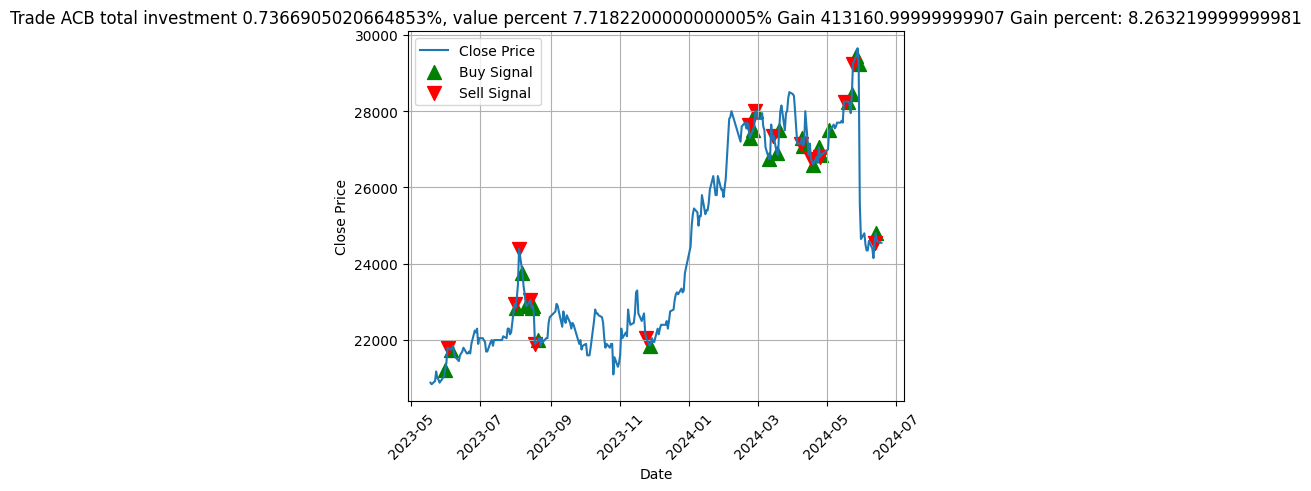

In [ ]:
print(last_total_investment)
print(investmentvalue)
print(total_gain)
print(investGain)

# Mark buy and sell actions
buy_signals = result[result['action'] == 1]
sell_signals = result[result['action'] == 2]
plt.plot(result['date'], result['close'], linestyle='-', label='Close Price')

plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='g', s=100, label='Buy Signal')
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='r', s=100, label='Sell Signal')

# Customize the plot
plt.title(f'Trade {symbol} total investment {last_total_investment}%, value percent {investmentvalue}% Gain {total_gain} Gain percent: {investGain}')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()

LSS WITH LSTM

In [ ]:
df = pd.read_csv(f'DataTraining/{symbol}.csv')
df['Date'] = pd.to_datetime(df['Date'])
df_init = df[['Close']]  
df_init = data_preprocessing(df_init, Feature_Extractor)
real_trend = df_init['Close'].tolist()
parameters = [df_init[cl].tolist() for cl in df_init.columns]
initial_money = 500000
minmax = pickle.load(open(f"checkpoint/{symbol}Prediction_LSSscaler.pkl", 'rb'))
scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
with open(f"checkpoint/{symbol}Prediction_LSSmodel.pkl", 'rb') as fopen:
    model = pickle.load(fopen)
df = df[['Date', 'Close']]
#Preprocess Dataframe
df = data_preprocessing(df, Feature_Extractor)
selected_data = df.loc[(df['Date'] >= from_date) & (df['Date'] <= to_date),:]
data_list = selected_data.values.tolist()

c:\Users\hotua\anaconda3\envs\venv\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
agent6 = LSSAgent(model = model,
                timeseries = scaled_parameters,
                skip = skip,
                initial_money = initial_money,
                real_trend = real_trend,
                minmax = minmax,
                window_size = 10)

In [ ]:
trade_results = []
for row in data_list:
    #ensure first column is Date
    date = row[0]
    value = row[1:]
    result = agent6.trade(value, date = date)
    trade_results.append(result)

[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]


In [ ]:
result = pd.DataFrame(trade_results)

# Convert the 'date' column to datetime format
result['date'] = pd.to_datetime(result['date'])
# total_gain = result['gain'].sum()
# total_investment = result['investment'].sum()

In [ ]:
result

,status,action,close,balance,timestamp,date,total,investment,total_investment,gain
0,data not enough to trade,0,28100.0,500000.0,2024-06-18 20:46:05.795261,2024-05-06,NaN,NaN,NaN,NaN
1,data not enough to trade,0,28300.0,500000.0,2024-06-18 20:46:05.795261,2024-05-07,NaN,NaN,NaN,NaN
2,data not enough to trade,0,27950.0,500000.0,2024-06-18 20:46:05.795261,2024-05-08,NaN,NaN,NaN,NaN
3,data not enough to trade,0,27800.0,500000.0,2024-06-18 20:46:05.795261,2024-05-09,NaN,NaN,NaN,NaN
4,data not enough to trade,0,27600.0,500000.0,2024-06-18 20:46:05.795261,2024-05-10,NaN,NaN,NaN,NaN
5,data not enough to trade,0,27250.0,500000.0,2024-06-18 20:46:05.796405,2024-05-13,NaN,NaN,NaN,NaN
6,data not enough to trade,0,27250.0,500000.0,2024-06-18 20:46:05.796405,2024-05-14,NaN,NaN,NaN,NaN
7,data not enough to trade,0,27800.0,500000.0,2024-06-18 20:46:05.796405,2024-05-15,NaN,NaN,NaN,NaN
8,data not enough to trade,0,28400.0,500000.0,2024-06-18 20:46:05.796405,2024-05-16,NaN,NaN,NaN,NaN
9,do nothing,0,28500.0,500000.0,2024-06-18 20:46:05.797809,2024-05-17,500000.0,NaN,NaN,NaN


In [ ]:
df_action_2 = result[result['action'] == 2]

# Sắp xếp DataFrame theo timestamp hoặc date để đảm bảo lấy hàng cuối cùng
df_action_2_sorted = df_action_2.sort_values(by='date')

# Lấy giá trị total_investment của hàng cuối cùng
last_total_investment = df_action_2_sorted.iloc[-1]['total_investment']
df_sorted = result.sort_values(by='date')

# Lấy giá trị total của hàng cuối cùng
last_total = df_sorted.iloc[-1]['total']
investmentvalue = (last_total-initial_money)/initial_money *100
total_gain = result['gain'].sum()
investGain = total_gain/initial_money *100

7.867310625317743
7.140000000000001
30950.0
6.1899999999999995


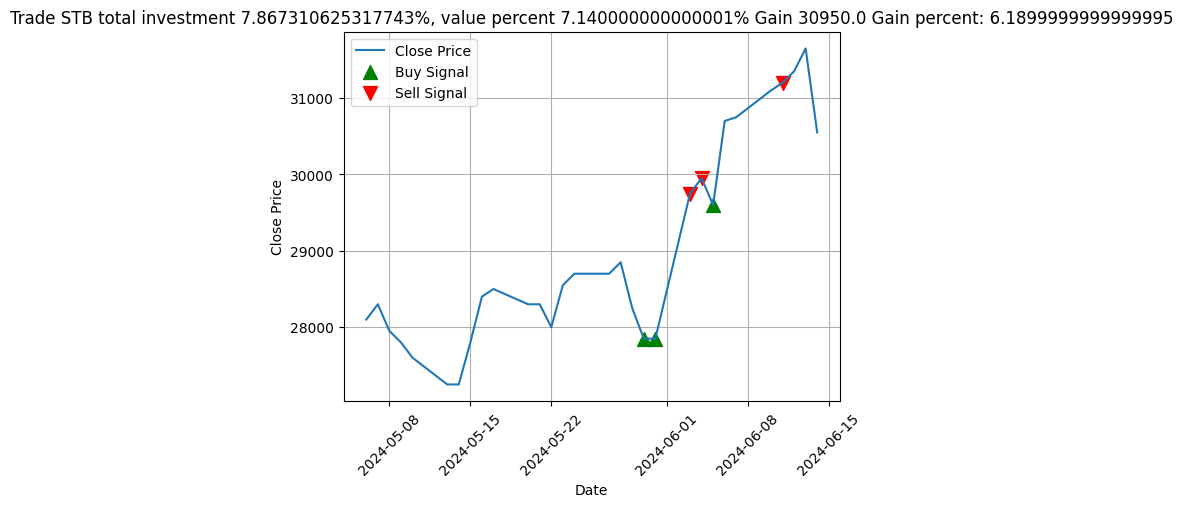

In [ ]:
print(last_total_investment)
print(investmentvalue)
print(total_gain)
print(investGain)

# Mark buy and sell actions
buy_signals = result[result['action'] == 1]
sell_signals = result[result['action'] == 2]
plt.plot(result['date'], result['close'], linestyle='-', label='Close Price')

plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='g', s=100, label='Buy Signal')
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='r', s=100, label='Sell Signal')

# Customize the plot
plt.title(f'Trade {symbol} total investment {last_total_investment}%, value percent {investmentvalue}% Gain {total_gain} Gain percent: {investGain}')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()